In [56]:
%load_ext autoreload
%autoreload 2
import sys, os
sys.path.insert(1, os.path.join(sys.path[0], '..'))

In [82]:
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

# Pipeline
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.externals import joblib

# Model selection
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import make_scorer, f1_score, classification_report, confusion_matrix

# Model
from sklearn.neighbors import KNeighborsClassifier

# Internal
from autocat.data.datasets import get_training_data
from autocat.data.features import CombinedFeatureAdder, feature_transactions_per_day, PandasDataFrameTransformer
from autocat.data.filters import FeatureFilters, no_null_StdUnitsShipped_StdNetAmount
from autocat.models import GridSearchModel
from autocat.models.evaluation import plot_learning_curve, evaluate
from autocat.models.pipelines import get_scaled_pipeline_v1

In [83]:
TRAINING_DATA = '../data/processed/train_2018-08-24.csv'

## Pipeline

In [84]:
# Create feaure matrix and label vector
X, y = get_training_data(TRAINING_DATA, [
    no_null_StdUnitsShipped_StdNetAmount
], drop_na=True)

In [78]:
print('Training instances:', len(X))

Training instances: 5610


In [85]:
# Create a pipeline to transform the modelling data
pipeline = get_scaled_pipeline_v1(X)

## Model

In [86]:
# Create the parameter grid to optimize
param_grid = [
    {
        'knn__n_neighbors': [1, 3, 5, 10, 25, 30, 45, 50], 
        'knn__metric': ['euclidean'],
        'knn__weights': ['uniform', 'distance']
    },
   {
       'knn__n_neighbors': [1, 3, 5, 10, 25, 30, 45, 50], 
       'knn__metric': ['minkowski'],
        'knn__weights': ['uniform', 'distance'],
       'knn__p': [1, 3]
    }
  ]

In [88]:
# Create the optimization model
scorer = make_scorer(f1_score, average='micro')
knn_model = GridSearchModel(param_grid, name='knn', model=KNeighborsClassifier(), pipeline=pipeline)
knn_model.train(X, y, 5, scorer)

In [89]:
# Final model
knn_model.model

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=25, p=1,
           weights='distance')

## Evaluation

#### Training Set

In [90]:
training_predictions = knn_model.model.predict(knn_model.pipeline.fit_transform(X))
print(classification_report(y, training_predictions))
print(f1_score(y, training_predictions, average='micro'))

                      precision    recall  f1-score   support

           Body Care       1.00      1.00      1.00       936
              Frozen       0.99      0.99      0.99       308
                Meat       1.00      1.00      1.00       102
    Packaged Grocery       0.99      1.00      1.00      3005
        Packaged Tea       1.00      0.99      0.99       222
Refrigerated Grocery       1.00      0.99      1.00       595
            Vitamins       1.00      0.98      0.99       442

         avg / total       1.00      1.00      1.00      5610

0.9951871657754011


#### Cross Validation

In [91]:
CV=10

In [92]:
cv_predictions = cross_val_predict(knn_model.get_model_pipeline(), X, y, cv=CV)
print(f1_score(y, cv_predictions, average='micro'))
print(classification_report(y, cv_predictions))

0.6982174688057041
                      precision    recall  f1-score   support

           Body Care       0.67      0.78      0.72       936
              Frozen       0.44      0.01      0.03       308
                Meat       0.90      0.62      0.73       102
    Packaged Grocery       0.72      0.91      0.80      3005
        Packaged Tea       0.52      0.07      0.12       222
Refrigerated Grocery       0.65      0.46      0.54       595
            Vitamins       0.56      0.25      0.34       442

         avg / total       0.67      0.70      0.65      5610



The KNN model performs well for the following categories: 
* Body Care
* Meat 
* Packaged Grocery

#### Confusion Matrix

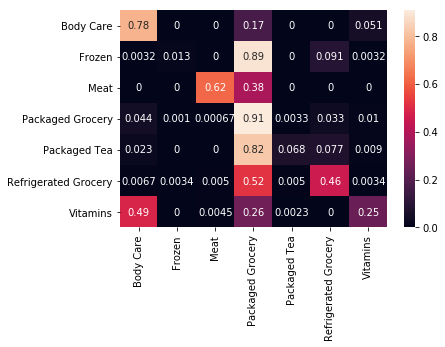

In [93]:
conf_mat = confusion_matrix(y, cv_predictions, labels=np.sort(y.unique()))
conf_mat_df = pd.DataFrame(
    conf_mat, 
    index=np.sort(y.unique()), 
    columns=np.sort(y.unique()))

conf_mat_props = pd.DataFrame(
    conf_mat_df.values / conf_mat_df.sum(axis=1)[:,None],
    index=np.sort(y.unique()), 
    columns=np.sort(y.unique()))

sns.heatmap(conf_mat_props, annot=True);

In [94]:
conf_mat_props.apply(lambda x: (x == 0).sum()).mean()

2.142857142857143

Clearly lots of items are getting mistaken as belonging to the Packaged Grocery category.  This is not surprising as Packaged Grocery is a relatively generic catgory that likely captures other categories.

#### Learning Curve

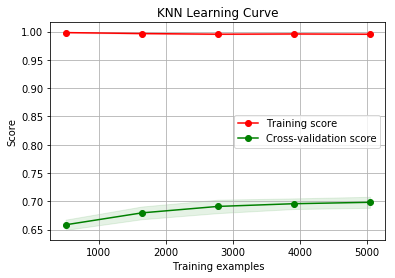

In [95]:
# Plot the learning curve
plot_learning_curve(knn_model.get_model_pipeline(), 'KNN Learning Curve', X, y, cv=CV, n_jobs=-1);

The KNN appears to be too complex given the number of training examples.